# Developing AI application that can recognize 102 species of flowers

In [1]:
import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import time
import json
import copy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_on_gpu = torch.cuda.is_available()

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}



dirs = {'train': train_dir, 
        'valid': valid_dir, 
        'test' : test_dir}

image_datasets = {x: datasets.ImageFolder(dirs[x],
                                          transform=data_transforms[x]) for x in ['train', 'valid', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=32, shuffle=True) for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

### Label mapping

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [6]:
#cat_to_name

# Building the training classifier

In [7]:
model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:14<00:00, 39057782.62it/s]


In [8]:
# model

In [9]:
print(f"input features: {model.classifier[6].in_features}") 
print(f"output features: {model.classifier[6].out_features}") 

input features: 4096
output features: 1000


In [10]:
for param in model.features.parameters():
    param.requires_grad = False

n_inputs = model.classifier[6].in_features

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(class_names))
model.classifier[6] = last_layer

if train_on_gpu:
    model.cuda()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

In [22]:
# number of epochs to train the model
n_epochs = 10
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for data, target in dataloaders['train']:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in dataloaders['valid']:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(dataloaders['train'].dataset)
    valid_loss = valid_loss/len(dataloaders['valid'].dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.392833 	Validation Loss: 1.904500
Validation loss decreased (inf --> 1.904500).  Saving model ...
Epoch: 2 	Training Loss: 2.023513 	Validation Loss: 1.574980
Validation loss decreased (1.904500 --> 1.574980).  Saving model ...
Epoch: 3 	Training Loss: 1.741326 	Validation Loss: 1.352041
Validation loss decreased (1.574980 --> 1.352041).  Saving model ...
Epoch: 4 	Training Loss: 1.534352 	Validation Loss: 1.178499
Validation loss decreased (1.352041 --> 1.178499).  Saving model ...
Epoch: 5 	Training Loss: 1.366289 	Validation Loss: 1.059502
Validation loss decreased (1.178499 --> 1.059502).  Saving model ...
Epoch: 6 	Training Loss: 1.277256 	Validation Loss: 0.966733
Validation loss decreased (1.059502 --> 0.966733).  Saving model ...
Epoch: 7 	Training Loss: 1.170509 	Validation Loss: 0.881093
Validation loss decreased (0.966733 --> 0.881093).  Saving model ...
Epoch: 8 	Training Loss: 1.099079 	Validation Loss: 0.827853
Validation loss decreased (0.88109

## Testing the Network

In [12]:
#load and test
print("Model Loading...")
model.load_state_dict(torch.load('model.pt'))
print("Model succefully loaded !")

Model Loading...
Model succefully loaded !


In [14]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.eval()
# iterate over test data
for data, target in dataloaders['test']:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(19):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(dataloaders['test'].dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(102):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('')

print(f"\nTest Accuracy (Overall): {round(100. * np.sum(class_correct) / np.sum(class_total), 4)}%")
print(f"\n({int(np.sum(class_correct))}/{int(np.sum(class_total))})")

Test Loss: 0.831064

Test Accuracy of     0: 66% ( 2/ 3)
Test Accuracy of     1: 66% ( 2/ 3)
Test Accuracy of     2: 66% ( 2/ 3)
Test Accuracy of     3: 50% ( 1/ 2)
Test Accuracy of     4: 100% ( 4/ 4)
Test Accuracy of     5: 50% ( 3/ 6)
Test Accuracy of     6: 100% ( 4/ 4)
Test Accuracy of     7: 66% ( 2/ 3)
Test Accuracy of     8: 100% ( 2/ 2)
Test Accuracy of     9: 100% ( 1/ 1)
Test Accuracy of    10:  0% ( 0/ 1)
Test Accuracy of    11: 100% ( 7/ 7)
Test Accuracy of    12: 50% ( 2/ 4)
Test Accuracy of    13: 60% ( 3/ 5)


Test Accuracy of    16:  0% ( 0/ 1)
Test Accuracy of    17: 100% ( 2/ 2)
Test Accuracy of    18: 100% ( 5/ 5)
Test Accuracy of    19: 100% ( 1/ 1)
Test Accuracy of    20: 100% ( 4/ 4)
Test Accuracy of    21: 40% ( 2/ 5)
Test Accuracy of    22: 100% ( 2/ 2)
Test Accuracy of    23: 100% ( 4/ 4)
Test Accuracy of    24: 100% ( 6/ 6)
Test Accuracy of    25: 50% ( 1/ 2)
Test Accuracy of    26: 75% ( 6/ 8)
Test Accuracy of    27:  0% ( 0/ 2)
Test Accuracy of    28: 66% (

# Inference for classification

## Image Preprocessing

In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    from PIL import Image
    img = Image.open(image)
    
    # Resize image
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
        
    # Crop image
    bottom_margin = (img.height-224)/2
    top_margin = bottom_margin + 224
    left_margin = (img.width-224)/2
    right_margin = left_margin + 224
    
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    
    # Normalize image
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean)/std
    
    # move to first dimension --> PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [18]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [19]:
!ls flowers/train/1

image_06734.jpg  image_06742.jpg  image_06751.jpg  image_06767.jpg
image_06735.jpg  image_06744.jpg  image_06753.jpg  image_06768.jpg
image_06736.jpg  image_06745.jpg  image_06757.jpg  image_06770.jpg
image_06737.jpg  image_06746.jpg  image_06759.jpg  image_06771.jpg
image_06738.jpg  image_06747.jpg  image_06761.jpg  image_06772.jpg
image_06740.jpg  image_06748.jpg  image_06762.jpg  image_06773.jpg
image_06741.jpg  image_06750.jpg  image_06766.jpg


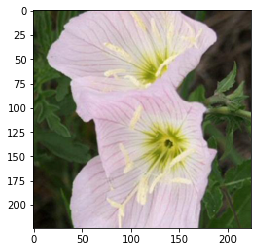

In [20]:
image_path = 'flowers/train/1/image_06744.jpg'
img = process_image(image_path)
imshow(img)

## Class Prediction

In [65]:
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    #process image
    img = process_image(image_path)
    #transform to tensor
    tensor_img = torch.from_numpy(img).type(torch.FloatTensor)
    #batch 1
    input_model = tensor_img.unsqueeze(0)

    #doesn't work on GPU and I don't know how, so I moved it to cpu
    model = model.cpu()
    log_results = model(input_model)
    proba = torch.exp(log_results)

    top_proba, top_label = proba.topk(top_k)
    top_proba = top_proba.detach().numpy().tolist()[0] 
    top_label = top_label.detach().numpy().tolist()[0]

    # transform indices to classes name
    idx_to_class = {val: key for key, val in image_datasets['train'].class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_label]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_label]
    
    return top_proba, top_labels, top_flowers

In [66]:
!ls flowers/test/1

image_06743.jpg  image_06754.jpg  image_06764.jpg
image_06752.jpg  image_06760.jpg


In [69]:
def plot_solution(image_path, model):
    import seaborn as sns
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = cat_to_name[flower_num]
    
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    
    # Make prediction
    probs, labs, flowers = predict(image_path, model)
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

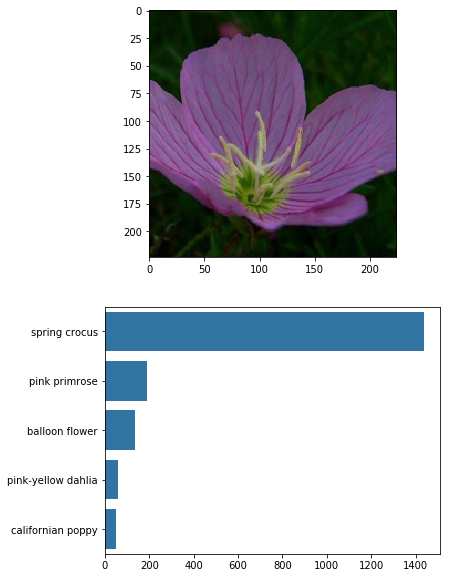

In [70]:
image_path = 'flowers/test/1/image_06752.jpg'
plot_solution(image_path, model)